
# 🏦 Home Credit Default Risk — End-to-End ML (XGBoost/LightGBM)

**Цель:** построить кредитный скоринг на открытых банковских данных Home Credit, показать:
- загрузку и агрегацию вспомогательных таблиц,
- EDA,
- подготовку и кодирование данных,
- обучение XGBoost и LightGBM,
- подбор гиперпараметров (через importance / топ-фичи + Grid/Optuna),
- сравнение моделей по **Gini** (и ROC-AUC),
- интерпретацию с помощью **feature importance** и **SHAP**,
- визуализацию.


In [ ]:
import os, zipfile
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score, roc_curve
import lightgbm as lgb
import xgboost as xgb
import shap
from sklearn.model_selection import StratifiedKFold



## 0) Установка окружения

> Выполните этот блок **один раз** (можно в отдельном терминале) и перезапустите ядро.


In [33]:

# Если нужно, раскомментируйте:
# !python -m venv home_credit
# !source home_credit/bin/activate  # Windows: .\home_credit\Scripts\Activate.ps1

# Библиотеки (поставьте один раз; в Colab часть уже предустановлена)
# Примечание: в локальной среде удалите "!" перед pip
# !pip install -U pandas numpy scikit-learn matplotlib plotly xgboost lightgbm optuna shap kaggle pyarrow



## 1) Загрузка датасета с Kaggle



In [ ]:
DATA_DIR = Path("data/home_credit")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Скачиваем все файлы соревнования
# Убедитесь, что у вас есть ~/.kaggle/kaggle.json
cmd = f'kaggle competitions download -c home-credit-default-risk -p "{DATA_DIR}"'
print(cmd)
os.system(cmd)

# Распаковываем все zip-архивы
for z in DATA_DIR.glob("*.zip"):
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

list(DATA_DIR.glob("*.csv"))


kaggle competitions download -c home-credit-default-risk -p "data/home_credit"
home-credit-default-risk.zip: Skipping, found more recently modified local copy (use --force to force download)


[PosixPath('data/home_credit/application_test.csv'),
 PosixPath('data/home_credit/HomeCredit_columns_description.csv'),
 PosixPath('data/home_credit/POS_CASH_balance.csv'),
 PosixPath('data/home_credit/credit_card_balance.csv'),
 PosixPath('data/home_credit/installments_payments.csv'),
 PosixPath('data/home_credit/application_train.csv'),
 PosixPath('data/home_credit/bureau.csv'),
 PosixPath('data/home_credit/previous_application.csv'),
 PosixPath('data/home_credit/bureau_balance.csv'),
 PosixPath('data/home_credit/sample_submission.csv')]


## 2) Загрузка всех таблиц


In [ ]:
app_train = pd.read_csv(DATA_DIR / "application_train.csv")
app_test  = pd.read_csv(DATA_DIR / "application_test.csv")
bureau            = pd.read_csv(DATA_DIR / "bureau.csv")
bureau_balance    = pd.read_csv(DATA_DIR / "bureau_balance.csv")
previous_app      = pd.read_csv(DATA_DIR / "previous_application.csv")
pos_cash_bal      = pd.read_csv(DATA_DIR / "POS_CASH_balance.csv")
installments_pay  = pd.read_csv(DATA_DIR / "installments_payments.csv")
credit_card_bal   = pd.read_csv(DATA_DIR / "credit_card_balance.csv")

(app_train.shape, app_test.shape,
 bureau.shape, bureau_balance.shape, previous_app.shape,
 pos_cash_bal.shape, installments_pay.shape, credit_card_bal.shape)


((307511, 122),
 (48744, 121),
 (1716428, 17),
 (27299925, 3),
 (1670214, 37),
 (10001358, 8),
 (13605401, 8),
 (3840312, 23))


## 3) Базовая очистка (минимальная)
- Убираем спец-код `DAYS_EMPLOYED == 365243` → NaN.
- Удаляем дубликаты по `SK_ID_CURR` (редко, но на всякий случай).


In [ ]:
for df in [app_train, app_test]:
    df.drop_duplicates(subset=["SK_ID_CURR"], inplace=True)
    df.loc[df["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = np.nan

app_train["TARGET"].value_counts(normalize=True)


TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


## 4) Агрегации вспомогательных таблиц → уровень клиента (`SK_ID_CURR`)

Схема:
- `bureau_balance` → агрегируем на `SK_ID_BUREAU`, затем join к `bureau`
- `bureau` → агрегируем на `SK_ID_CURR`
- Аналогично: `previous_application`, `POS_CASH_balance`, `installments_payments`, `credit_card_balance` → агрегируем на `SK_ID_CURR`
- В конце — join к `application_train/test` по `SK_ID_CURR`.


In [ ]:
def one_hot(df, cols=None):
    if cols is None:
        cols = df.select_dtypes(include=["object","category"]).columns.tolist()
    return pd.get_dummies(df, columns=cols, dummy_na=True)

def safe_aggr(df: pd.DataFrame, group_key: str, exclude: list[str] = None,
              agg=("mean","sum","max","min"), prefix: str = "") -> pd.DataFrame:
    exclude = set((exclude or [])) | {group_key}
    cols = [c for c in df.columns if c not in exclude]
    out = df.groupby(group_key)[cols].agg(list(agg)).reset_index()
    out.columns = [group_key] + [f"{prefix}{c}_{a}" for c in cols for a in agg]
    return out

bb_oh = one_hot(bureau_balance)
bb_aggr = safe_aggr(
    bb_oh, group_key="SK_ID_BUREAU",
    exclude=[],                       # ключ исключим внутри safe_aggr
    agg=("mean","sum","max","min"),
    prefix="bb__"                     # префиксируем источник!
)

bureau_merged = bureau.merge(bb_aggr, how="left", on="SK_ID_BUREAU")

# one-hot и агрегируем до уровня клиента
bureau_oh = one_hot(bureau_merged)
# Важно: исключаем оба ID-столбца, чтобы они не попали в агрегации
bureau_aggr = safe_aggr(
    bureau_oh, group_key="SK_ID_CURR",
    exclude=["SK_ID_BUREAU"],         # не агрегировать ключи
    agg=("mean","sum","max","min"),
    prefix="bureau__"
)

prev_oh = one_hot(previous_app)
prev_aggr = safe_aggr(
    prev_oh, group_key="SK_ID_CURR",
    exclude=["SK_ID_PREV"],           # не агрегируем ID заявки
    agg=("mean","sum","max","min"),
    prefix="prev__"
)

pos_oh = one_hot(pos_cash_bal)
pos_aggr = safe_aggr(
    pos_oh, group_key="SK_ID_CURR",
    exclude=["SK_ID_PREV"],
    agg=("mean","sum","max","min"),
    prefix="pos__"
)

ins_oh = one_hot(installments_pay)
ins_aggr = safe_aggr(
    ins_oh, group_key="SK_ID_CURR",
    exclude=["SK_ID_PREV"],
    agg=("mean","sum","max","min"),
    prefix="ins__"
)

cc_oh = one_hot(credit_card_bal)
cc_aggr = safe_aggr(
    cc_oh, group_key="SK_ID_CURR",
    exclude=["SK_ID_PREV"],
    agg=("mean","sum","max","min"),
    prefix="cc__"
)

# ==== финальное объединение к application_* по SK_ID_CURR ====
def merge_all(app):
    df = app.copy()
    for add in [bureau_aggr, prev_aggr, pos_aggr, ins_aggr, cc_aggr]:
        df = df.merge(add, how="left", on="SK_ID_CURR")
    return df

train_full = merge_all(app_train)
test_full  = merge_all(app_test)

train_full.to_parquet(DATA_DIR / "train_full.parquet")
test_full.to_parquet(DATA_DIR / "test_full.parquet")

train_full.shape, test_full.shape


((307511, 1466), (48744, 1465))


## 5) Быстрый EDA


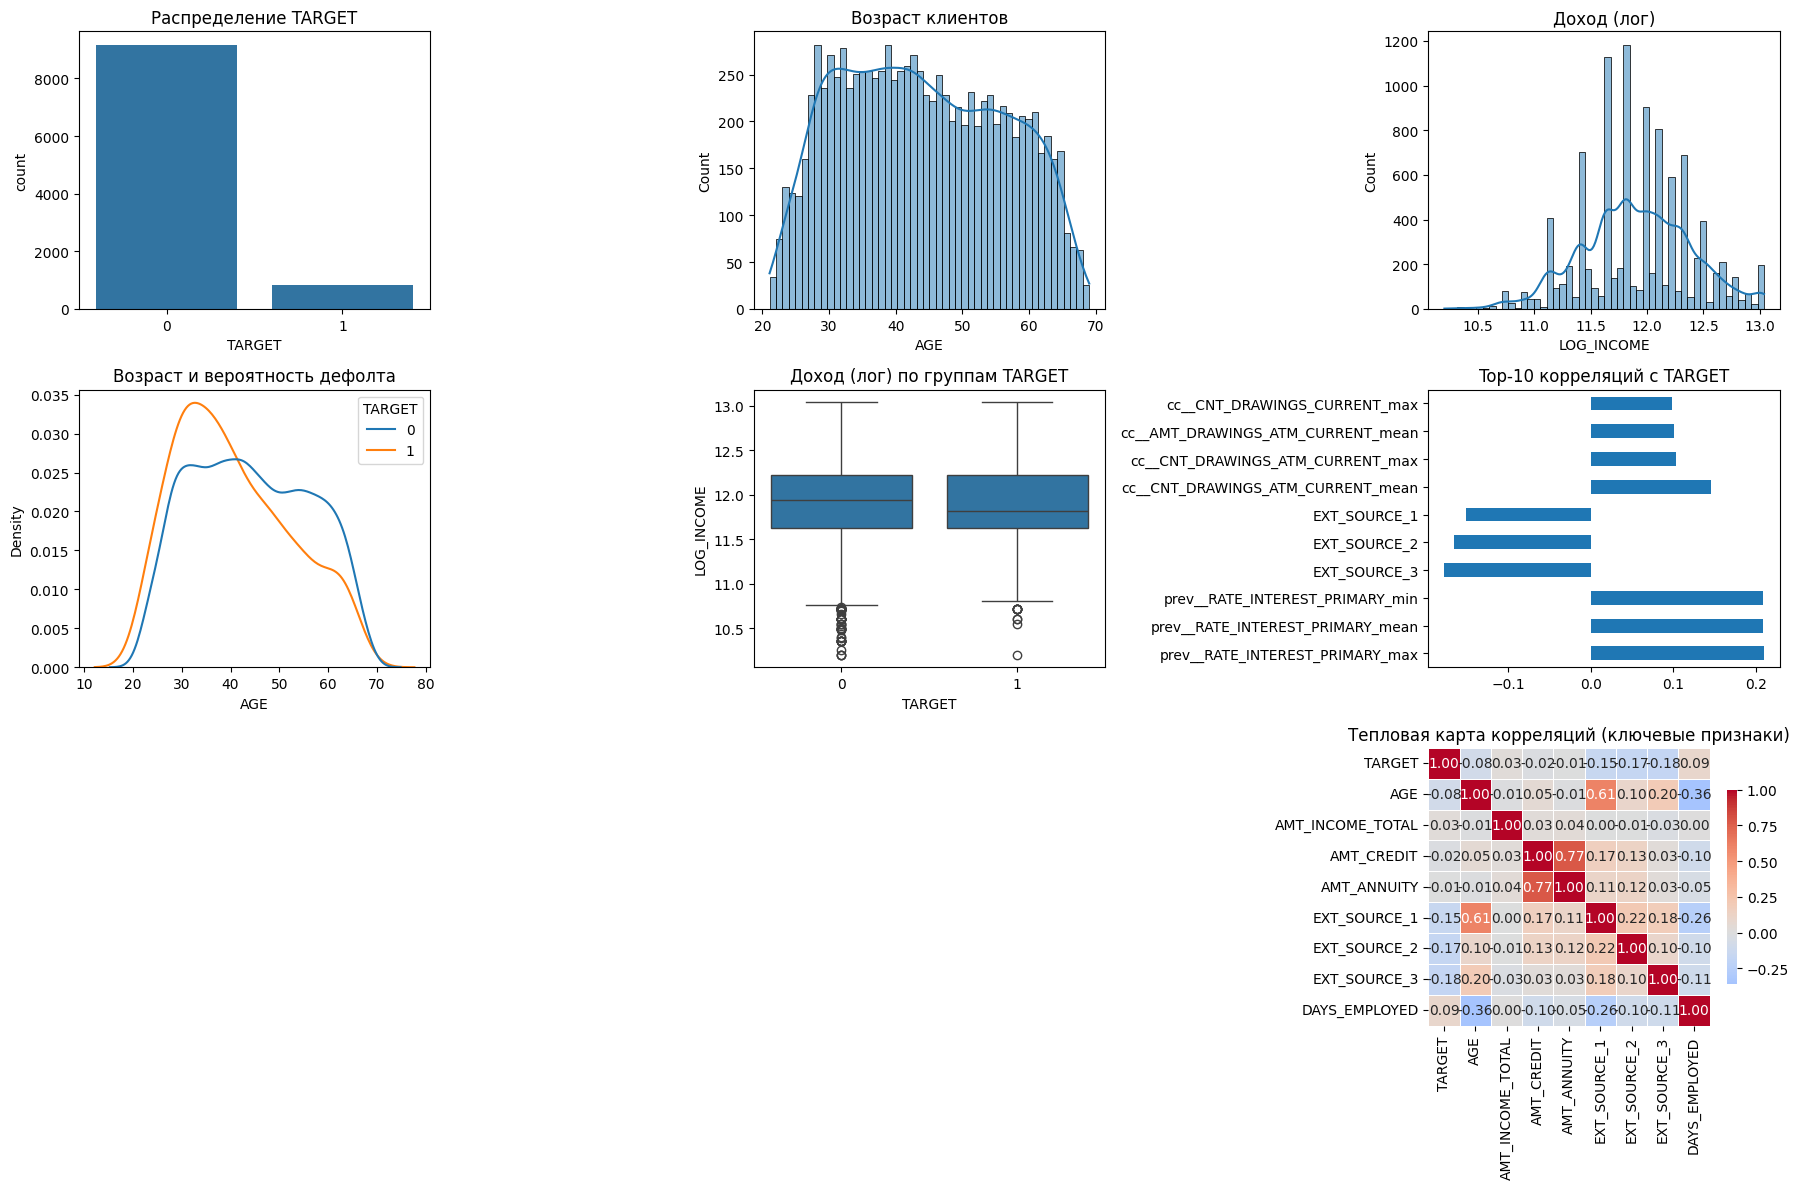

In [ ]:
# ===== Подготовка данных =====
df = train_full.sample(10000, random_state=42) if len(train_full) > 10000 else train_full.copy()
df["AGE"] = -df["DAYS_BIRTH"] / 365
df["LOG_INCOME"] = np.log1p(df["AMT_INCOME_TOTAL"].clip(upper=df["AMT_INCOME_TOTAL"].quantile(0.99)))
df["LOG_CREDIT"] = np.log1p(df["AMT_CREDIT"].clip(upper=df["AMT_CREDIT"].quantile(0.99)))

# ===== Создаём фигуру 3x3 (добавляем место под heatmap) =====
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

# 1. TARGET
sns.countplot(x="TARGET", data=df, ax=axes[0])
axes[0].set_title("Распределение TARGET")

# 2. Возраст
sns.histplot(df["AGE"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Возраст клиентов")

# 3. Доход (лог)
sns.histplot(df["LOG_INCOME"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Доход (лог)")

# 4. Возраст vs TARGET
sns.kdeplot(data=df, x="AGE", hue="TARGET", common_norm=False, ax=axes[3])
axes[3].set_title("Возраст и вероятность дефолта")

# 5. Доход vs TARGET
sns.boxplot(data=df, x="TARGET", y="LOG_INCOME", ax=axes[4])
axes[4].set_title("Доход (лог) по группам TARGET")

# 6. Топ-10 корреляций
num_cols = df.select_dtypes(include=[np.number]).columns
corr_series = df[num_cols].corr()["TARGET"].sort_values(key=np.abs, ascending=False).head(11)
corr_series.iloc[1:].plot(kind="barh", ax=axes[5])
axes[5].set_title("Top-10 корреляций с TARGET")

# 7–8 — пустые ячейки для равномерного размещения
axes[6].axis("off")
axes[7].axis("off")

# 9. Тепловая карта корреляций
corr_features = [
    "TARGET",
    "AGE",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "DAYS_EMPLOYED",
]
cols_exist = [c for c in corr_features if c in df.columns]
corr_matrix = df[cols_exist].corr(numeric_only=True)

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    ax=axes[8]
)
axes[8].set_title("Тепловая карта корреляций (ключевые признаки)")

plt.tight_layout()
plt.show()



## 6) Подготовка и кодирование + разбиение train/val/test


LightGBM → AUC: 0.7831 | GINI: 0.5663
XGBoost → AUC: 0.7850 | GINI: 0.5699


/var/folders/v9/c4d6j8t16p3_3bct2sxd0sw00000gn/T/ipykernel_32412/1058148251.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x="Importance", y="Feature", palette="coolwarm")


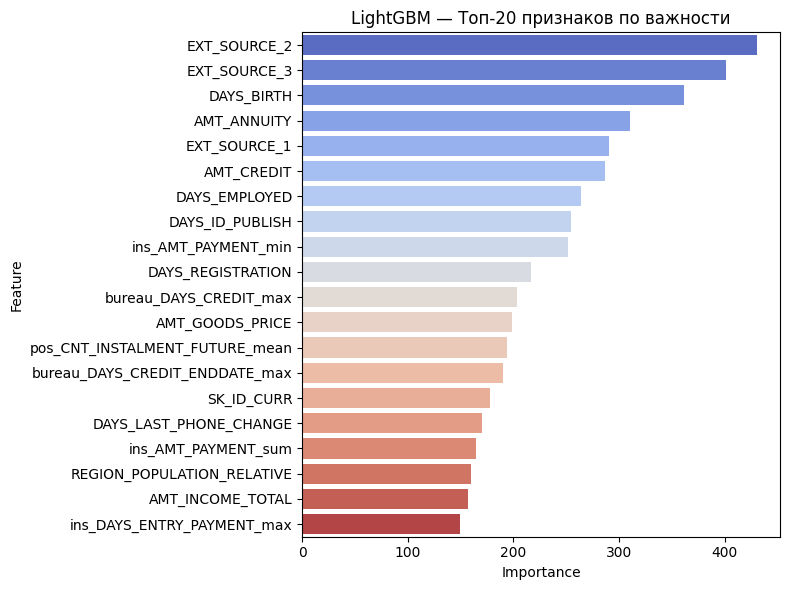

/var/folders/v9/c4d6j8t16p3_3bct2sxd0sw00000gn/T/ipykernel_32412/1058148251.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x="Importance", y="Feature", palette="coolwarm")


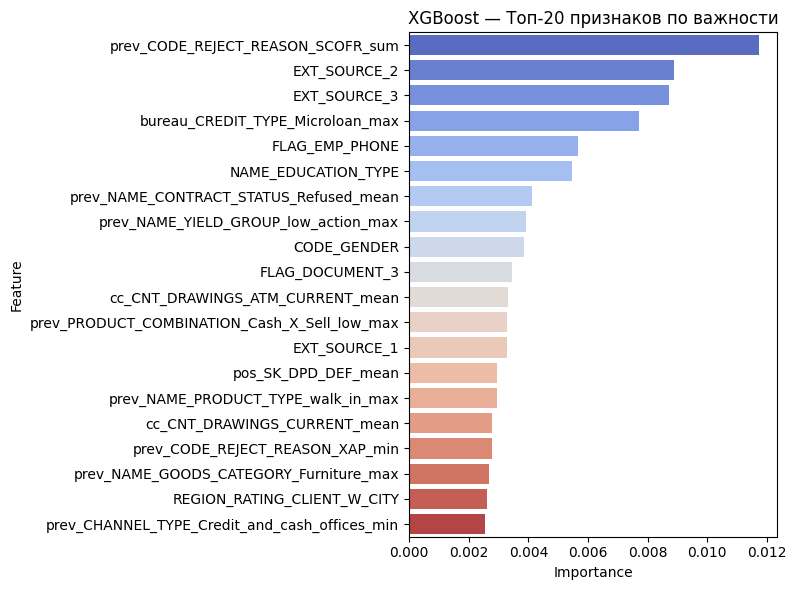

,Model,AUC,GINI
0,LightGBM,0.783146,0.566293
1,XGBoost,0.784969,0.569939


In [ ]:
# === МОДЕЛИРОВАНИЕ ===
# Загружаем финальные датасеты (из parquet)
train_full = pd.read_parquet(DATA_DIR / "train_full.parquet")

# Разделил фичи и таргет
y = train_full["TARGET"]
X = train_full.drop(columns=["TARGET"])

# Категориальные -> LabelEncoder (для LightGBM и XGB одинаково)
cat_cols = X.select_dtypes(include=["object", "category"]).columns
for c in cat_cols:
    X[c] = LabelEncoder().fit_transform(X[c].astype(str))

# Пропуски -> 0 (или медиана — но 0 для ускорения)
X = X.fillna(0)

def sanitize_feature_names(df: pd.DataFrame) -> pd.DataFrame:
    # Заменяем проблемные символы: ", ', \, [, ], {, }, :, табы/переводы строк и пр. на "_"
    bad = r'["\'\\\[\]\{\}:,\n\r\t]'
    new_cols = (
        df.columns
          .str.replace(bad, "_", regex=True)
          .str.replace(r"\s+", "_", regex=True)   # пробелы -> _
          .str.replace(r"[^0-9A-Za-z_]", "_", regex=True)  # всё остальное нестандартное -> _
          .str.replace(r"__+", "_", regex=True)   # сжать повторы _
          .str.strip("_")
    )
    df = df.copy()
    df.columns = new_cols

    # На всякий случай устраним возможные дубли после санации
    if df.columns.duplicated().any():
        counts = {}
        safe_cols = []
        for c in df.columns:
            if c not in counts:
                counts[c] = 0
                safe_cols.append(c)
            else:
                counts[c] += 1
                safe_cols.append(f"{c}__{counts[c]}")
        df.columns = safe_cols
    return df

X = sanitize_feature_names(X)


# Train / Valid split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict_proba(X_val)[:, 1]
lgb_auc = roc_auc_score(y_val, lgb_pred)
lgb_gini = 2 * lgb_auc - 1
print(f"LightGBM → AUC: {lgb_auc:.4f} | GINI: {lgb_gini:.4f}")

# XGBoost
xgb_model = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(y_val, xgb_pred)
xgb_gini = 2 * xgb_auc - 1
print(f"XGBoost → AUC: {xgb_auc:.4f} | GINI: {xgb_gini:.4f}")

# Сравнение важности фич (feature importance)
def plot_feature_importance(model, model_name, top_n=20):
    importance = pd.DataFrame({
        "Feature": X.columns,
        "Importance": model.feature_importances_
    }).sort_values(by="Importance", ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=importance, x="Importance", y="Feature", palette="coolwarm")
    plt.title(f"{model_name} — Топ-{top_n} признаков по важности")
    plt.tight_layout()
    plt.show()

plot_feature_importance(lgb_model, "LightGBM")
plot_feature_importance(xgb_model, "XGBoost")

# Вывод сравнительных результатов
models_compare = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost"],
    "AUC": [lgb_auc, xgb_auc],
    "GINI": [lgb_gini, xgb_gini]
})
display(models_compare)



## 7) Базовые модели: LightGBM и XGBoost + Importance


[info] X shape = (307511, 1465), y pos_rate = 0.0807


[I 2025-11-10 17:05:36,874] A new study created in memory with name: lgbm_full


[info] scale_pos_weight = 11.387 (neg/pos)


  0%|          | 0/15 [00:00<?, ?it/s]

Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's auc: 0.77622


Best trial: 0. Best value: 0.77622:   7%|▋         | 1/15 [01:39<23:07, 99.07s/it]

[I 2025-11-10 17:07:15,954] Trial 0 finished with value: 0.7762202230855295 and parameters: {'learning_rate': 0.010731079176174468, 'num_leaves': 229, 'max_depth': 2, 'min_child_samples': 13, 'subsample': 0.9942870822018547, 'colsample_bytree': 0.8155298747776163, 'reg_alpha': 0.7900505944979879, 'reg_lambda': 0.750844981125416}. Best is trial 0 with value: 0.7762202230855295.
Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's auc: 0.78513


Best trial: 1. Best value: 0.78513:  13%|█▎        | 2/15 [03:36<23:45, 109.62s/it]

[I 2025-11-10 17:09:12,956] Trial 1 finished with value: 0.7851304670206035 and parameters: {'learning_rate': 0.021769481415377108, 'num_leaves': 228, 'max_depth': 3, 'min_child_samples': 116, 'subsample': 0.6217059080652683, 'colsample_bytree': 0.9597843575945669, 'reg_alpha': 0.585536271554064, 'reg_lambda': 0.7372677284643466}. Best is trial 1 with value: 0.7851304670206035.
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1104]	valid_0's auc: 0.786738


Best trial: 2. Best value: 0.786738:  20%|██        | 3/15 [06:10<26:03, 130.30s/it]

[I 2025-11-10 17:11:47,861] Trial 2 finished with value: 0.7867384115851179 and parameters: {'learning_rate': 0.015265101086827205, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 96, 'subsample': 0.7667285624241793, 'colsample_bytree': 0.6038886005779127, 'reg_alpha': 0.670164929683331, 'reg_lambda': 0.648780816584734}. Best is trial 2 with value: 0.7867384115851179.
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[860]	valid_0's auc: 0.784621


Best trial: 2. Best value: 0.786738:  27%|██▋       | 4/15 [07:32<20:21, 111.03s/it]

[I 2025-11-10 17:13:09,364] Trial 3 finished with value: 0.784620772304857 and parameters: {'learning_rate': 0.0318513706059232, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 101, 'subsample': 0.9540630906005405, 'colsample_bytree': 0.7911027369448346, 'reg_alpha': 0.07705442612554424, 'reg_lambda': 0.44236420031901313}. Best is trial 2 with value: 0.7867384115851179.
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1601]	valid_0's auc: 0.785522


Best trial: 2. Best value: 0.786738:  33%|███▎      | 5/15 [09:55<20:26, 122.66s/it]

[I 2025-11-10 17:15:32,627] Trial 4 finished with value: 0.7855220652601747 and parameters: {'learning_rate': 0.013914199632321354, 'num_leaves': 250, 'max_depth': 6, 'min_child_samples': 113, 'subsample': 0.6336391356203762, 'colsample_bytree': 0.815111809691283, 'reg_alpha': 0.32891644054642777, 'reg_lambda': 0.6033455235177521}. Best is trial 2 with value: 0.7867384115851179.
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[548]	valid_0's auc: 0.785211


Best trial: 2. Best value: 0.786738:  40%|████      | 6/15 [11:53<18:10, 121.14s/it]

[I 2025-11-10 17:17:30,814] Trial 5 finished with value: 0.7852110587548048 and parameters: {'learning_rate': 0.019611343599546038, 'num_leaves': 130, 'max_depth': 12, 'min_child_samples': 96, 'subsample': 0.7729345620983368, 'colsample_bytree': 0.70803368338041, 'reg_alpha': 0.44477612544790157, 'reg_lambda': 0.6542748323234072}. Best is trial 2 with value: 0.7867384115851179.
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[652]	valid_0's auc: 0.786478


Best trial: 2. Best value: 0.786738:  47%|████▋     | 7/15 [13:23<15:18, 114.84s/it]
[I 2025-11-10 17:19:00,771] A new study created in memory with name: xgb_full


[I 2025-11-10 17:19:00,767] Trial 6 finished with value: 0.7864775135239541 and parameters: {'learning_rate': 0.02352049640048556, 'num_leaves': 50, 'max_depth': 11, 'min_child_samples': 75, 'subsample': 0.7849085104462763, 'colsample_bytree': 0.62588025698288, 'reg_alpha': 0.7936916311402373, 'reg_lambda': 0.544824652649808}. Best is trial 2 with value: 0.7867384115851179.

[LGBM] best AUC : 0.7867384115851179
[LGBM] best Gini: 0.5734768231702358
[LGBM] best params: {'learning_rate': 0.015265101086827205, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 96, 'subsample': 0.7667285624241793, 'colsample_bytree': 0.6038886005779127, 'reg_alpha': 0.670164929683331, 'reg_lambda': 0.648780816584734}


Best trial: 0. Best value: 0.785783:   7%|▋         | 1/15 [07:03<1:38:43, 423.12s/it]

[I 2025-11-10 17:26:03,891] Trial 0 finished with value: 0.7857830648491829 and parameters: {'learning_rate': 0.016419120018364288, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8739453617910051, 'colsample_bytree': 0.8225042754795353, 'gamma': 0.7176608410673713, 'reg_lambda': 1.2163011880869086, 'reg_alpha': 0.4301148036135376}. Best is trial 0 with value: 0.7857830648491829.


Best trial: 0. Best value: 0.785783:  13%|█▎        | 2/15 [09:00<52:44, 243.44s/it]  

[I 2025-11-10 17:28:01,555] Trial 1 finished with value: 0.7812198388827919 and parameters: {'learning_rate': 0.07801556915522542, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6877937133043331, 'colsample_bytree': 0.7069381379184903, 'gamma': 1.8637124737603994, 'reg_lambda': 0.2635553838583029, 'reg_alpha': 0.22838472503114593}. Best is trial 0 with value: 0.7857830648491829.


Best trial: 0. Best value: 0.785783:  20%|██        | 3/15 [12:12<44:00, 220.03s/it]

[I 2025-11-10 17:31:13,727] Trial 2 finished with value: 0.7838942996105214 and parameters: {'learning_rate': 0.03237526950973665, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7183107442685542, 'colsample_bytree': 0.8728995347389317, 'gamma': 2.9897174651918923, 'reg_lambda': 1.7820398728440443, 'reg_alpha': 0.2881306955668508}. Best is trial 0 with value: 0.7857830648491829.


Best trial: 0. Best value: 0.785783:  27%|██▋       | 4/15 [17:29<47:17, 257.96s/it]

[I 2025-11-10 17:36:29,842] Trial 3 finished with value: 0.7687260004651756 and parameters: {'learning_rate': 0.016325298978533385, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.7423040438084827, 'colsample_bytree': 0.7747448143436882, 'gamma': 0.8880065363207745, 'reg_lambda': 1.090203533884675, 'reg_alpha': 0.05244643715622943}. Best is trial 0 with value: 0.7857830648491829.


Best trial: 0. Best value: 0.785783:  33%|███▎      | 5/15 [21:47<43:35, 261.51s/it]

[I 2025-11-10 17:40:48,311] Trial 4 finished with value: 0.7830203212077382 and parameters: {'learning_rate': 0.019842950994108283, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.6714530692286914, 'colsample_bytree': 0.9189657678326985, 'gamma': 1.233675661634643, 'reg_lambda': 1.4644171310527232, 'reg_alpha': 1.7635470614911013}. Best is trial 0 with value: 0.7857830648491829.

[XGB] best AUC : 0.7857830648491829
[XGB] best Gini: 0.5715661296983658
[XGB] best params: {'learning_rate': 0.016419120018364288, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8739453617910051, 'colsample_bytree': 0.8225042754795353, 'gamma': 0.7176608410673713, 'reg_lambda': 1.2163011880869086, 'reg_alpha': 0.4301148036135376}


,Study,Trial,AUC,Gini
7,XGBoost,0,0.785783,0.571566
8,XGBoost,1,0.781220,0.562440
9,XGBoost,2,0.783894,0.567789
10,XGBoost,3,0.768726,0.537452
11,XGBoost,4,0.783020,0.566041


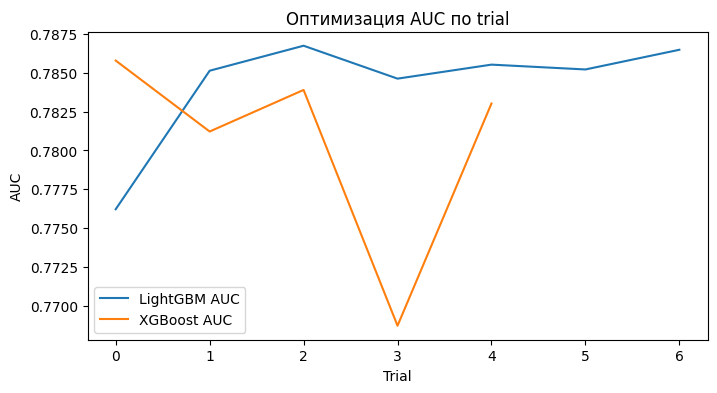

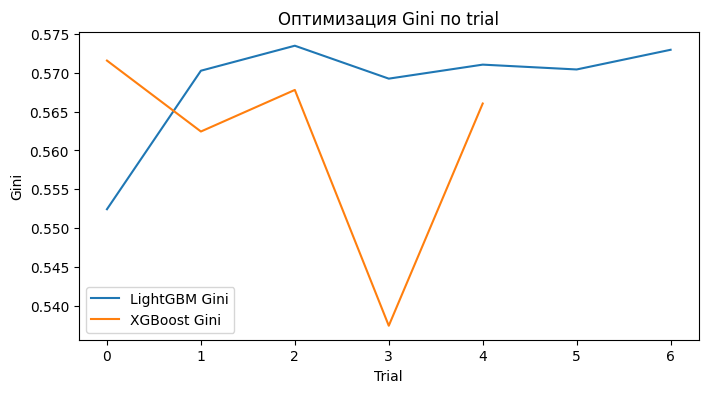

,Model,Best AUC,Best Gini
0,LightGBM,0.786738,0.573477
1,XGBoost,0.785783,0.571566


In [ ]:
# === 7) Optuna: тюнинг гиперпараметров на полном X/y ===
# ---- 7.0 sanity checks ----
assert "X" in globals() and "y" in globals(), "Ожидаю X и y из шага 6"
assert len(X) == len(y), "X и y должны быть одинаковой длины"
print(f"[info] X shape = {X.shape}, y pos_rate = {y.mean():.4f}")

# # ---- 7.1 утилиты ----
# def sanitize_feature_names(df: pd.DataFrame) -> pd.DataFrame:
#     """Чистим имена колонок для совместимости с LightGBM (кавычки, скобки и спецсимволы)."""
#     bad = r'["\'\\\[\]\{\}:,\n\r\t]'
#     new_cols = (df.columns
#                 .str.replace(bad, "_", regex=True)
#                 .str.replace(r"\s+", "_", regex=True)
#                 .str.replace(r"[^0-9A-Za-z_]", "_", regex=True)
#                 .str.replace(r"__+", "_", regex=True)
#                 .str.strip("_"))
#     out = df.copy()
#     out.columns = new_cols
#     if out.columns.duplicated().any():
#         counts = {}
#         safe = []
#         for c in out.columns:
#             if c in counts:
#                 counts[c] += 1
#                 safe.append(f"{c}__{counts[c]}")
#             else:
#                 counts[c] = 0
#                 safe.append(c)
#         out.columns = safe
#     return out

def gini_from_proba(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    return auc, 2.0 * auc - 1.0

def make_dual_patience(patience=4, min_delta=5e-4):
    """
    Останавливаем исследование, когда НЕТ улучшения AUC И Gini одновременно N trial'ов подряд.
    AUC — основная метрика (trial.value), Gini — из trial.user_attrs["gini"].
    """
    state = {"auc_best": -np.inf, "gini_best": -np.inf,
             "auc_since": 0, "gini_since": 0}
    def _cb(study: optuna.Study, trial: optuna.trial.FrozenTrial):
        if trial.value is None:
            return
        # AUC
        if trial.value > state["auc_best"] + min_delta:
            state["auc_best"] = trial.value
            state["auc_since"] = 0
        else:
            state["auc_since"] += 1
        # Gini (может отсутствовать, если trial упал — тогда игнор)
        gini = trial.user_attrs.get("gini", None)
        if gini is not None:
            if gini > state["gini_best"] + min_delta:
                state["gini_best"] = gini
                state["gini_since"] = 0
            else:
                state["gini_since"] += 1
        # Ранняя остановка при плато по обеим метрикам
        if state["auc_since"] >= patience and state["gini_since"] >= patience:
            study.stop()
    return _cb

# ---- 7.2 подготовка данных ----
# санитизация фич (защита от LightGBMError: special JSON characters)
X = sanitize_feature_names(X)

# фиксированный сплит для тюнинга
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# дисбаланс классов
pos = float((y_train == 1).sum())
neg = float((y_train == 0).sum())
scale_pos_weight = neg / max(pos, 1.0)
print(f"[info] scale_pos_weight = {scale_pos_weight:.3f} (neg/pos)")

# ---- 7.3 настройки тюнинга ----
N_TRIALS_LGB = 15     # можно увеличить, если нужно
N_TRIALS_XGB = 15
EARLY_STOP_ROUNDS = 150
NUM_BOOST_ROUND  = 2500

# прюнер и сэмплер Optuna
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=8)
sampler = optuna.samplers.TPESampler(n_startup_trials=5, multivariate=True)

# колбэки останова по плато
cb_lgb = make_dual_patience(patience=4, min_delta=5e-4)
cb_xgb = make_dual_patience(patience=4, min_delta=5e-4)

# ---- 7.4 LightGBM objective ----
def objective_lgb(trial):
    params = dict(
        objective="binary",
        metric="auc",
        boosting_type="gbdt",
        n_estimators=NUM_BOOST_ROUND,
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.08, log=True),
        num_leaves=trial.suggest_int("num_leaves", 31, 255),
        max_depth=trial.suggest_int("max_depth", -1, 12),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 120),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 0.8),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 0.8),
        max_bin=255,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
        verbosity=-1,
    )

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(EARLY_STOP_ROUNDS)]
    )
    proba = model.predict_proba(X_val)[:, 1]
    auc, gini = gini_from_proba(y_val, proba)
    trial.set_user_attr("gini", gini)  # логируем Gini для отчёта
    return auc

study_lgb = optuna.create_study(
    direction="maximize", pruner=pruner, sampler=sampler, study_name="lgbm_full"
)
study_lgb.optimize(objective_lgb, n_trials=N_TRIALS_LGB, callbacks=[cb_lgb], show_progress_bar=True)

print("\n[LGBM] best AUC :", study_lgb.best_value)
print("[LGBM] best Gini:", study_lgb.best_trial.user_attrs["gini"])
print("[LGBM] best params:", study_lgb.best_params)

# ---- 7.5 XGBoost objective (CPU-устойчивый) ----
def objective_xgb(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "eta": trial.suggest_float("learning_rate", 0.01, 0.08, log=True),  # = learning_rate
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),  # L2
        "alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),    # L1
        "tree_method": "hist",          # CPU OK (без GPU)
        "scale_pos_weight": scale_pos_weight,
        "seed": 42,
        "nthread": -1,
        # ВАЖНО: НЕ указываем sampling_method="gradient_based" — на CPU это ломает обучение
    }

    dtr = xgb.DMatrix(X_train, label=y_train)
    dva = xgb.DMatrix(X_val, label=y_val)
    evals = [(dtr, "train"), (dva, "valid")]

    booster = xgb.train(
        params=params,
        dtrain=dtr,
        num_boost_round=NUM_BOOST_ROUND,
        evals=evals,
        early_stopping_rounds=EARLY_STOP_ROUNDS,
        verbose_eval=False,
    )

    # совместимый предикт
    if hasattr(booster, "best_iteration") and booster.best_iteration is not None:
        proba = booster.predict(dva, iteration_range=(0, booster.best_iteration + 1))
    else:
        proba = booster.predict(dva)

    auc, gini = gini_from_proba(y_val, proba)
    trial.set_user_attr("gini", gini)
    return auc

study_xgb = optuna.create_study(
    direction="maximize", pruner=pruner, sampler=sampler, study_name="xgb_full"
)
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS_XGB, callbacks=[cb_xgb], show_progress_bar=True)

print("\n[XGB] best AUC :", study_xgb.best_value)
print("[XGB] best Gini:", study_xgb.best_trial.user_attrs["gini"])
print("[XGB] best params:", study_xgb.best_params)

# ---- 7.6 История и визуализация ----
def study_history(study, name):
    rows = []
    for t in study.trials:
        if t.values is None:
            continue
        rows.append(dict(
            Study=name,
            Trial=t.number,
            AUC=t.value,
            Gini=t.user_attrs.get("gini", float("nan"))
        ))
    return pd.DataFrame(rows)

hist = pd.concat([
    study_history(study_lgb, "LightGBM"),
    study_history(study_xgb, "XGBoost")
], ignore_index=True)

display(hist.sort_values(["Study", "Trial"]).tail())

plt.figure(figsize=(8,4))
for name, g in hist.groupby("Study"):
    g = g.sort_values("Trial")
    plt.plot(g["Trial"], g["AUC"], label=f"{name} AUC")
plt.title("Оптимизация AUC по trial")
plt.xlabel("Trial"); plt.ylabel("AUC"); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
for name, g in hist.groupby("Study"):
    g = g.sort_values("Trial")
    plt.plot(g["Trial"], g["Gini"], label=f"{name} Gini")
plt.title("Оптимизация Gini по trial")
plt.xlabel("Trial"); plt.ylabel("Gini"); plt.legend(); plt.show()

summary = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost"],
    "Best AUC": [study_lgb.best_value, study_xgb.best_value],
    "Best Gini": [study_lgb.best_trial.user_attrs["gini"], study_xgb.best_trial.user_attrs["gini"]],
})
display(summary.sort_values("Best Gini", ascending=False))



## 8) Подбор параметров через importance (TOP-k фич)
- Берём TOP-k признаков по importance LightGBM.
- Делаем подбор гиперпараметров на этих признаках (Grid или Optuna).


Final LGB params: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'n_estimators': 3000, 'learning_rate': 0.015265101086827205, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 96, 'subsample': 0.7667285624241793, 'colsample_bytree': 0.6038886005779127, 'reg_alpha': 0.670164929683331, 'reg_lambda': 0.648780816584734, 'random_state': 42, 'n_jobs': -1, 'scale_pos_weight': 11.38710976837865}
Final XGB params: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'eta': 0.016419120018364288, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8739453617910051, 'colsample_bytree': 0.8225042754795353, 'gamma': 0.7176608410673713, 'lambda': 1.2163011880869086, 'alpha': 0.4301148036135376, 'tree_method': 'hist', 'scale_pos_weight': 11.38710976837865, 'seed': 42, 'nthread': -1}
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1104]	valid_0's auc: 0.786738
[LGB] AUC=0.786738 | GINI=0.573477


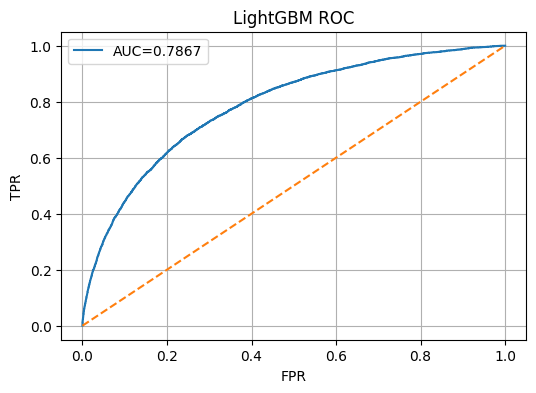

[XGB] AUC=0.785783 | GINI=0.571566


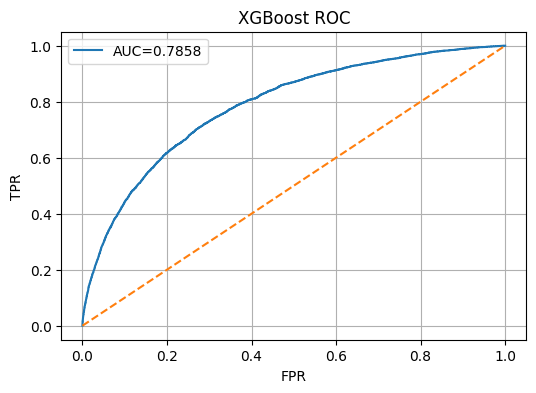

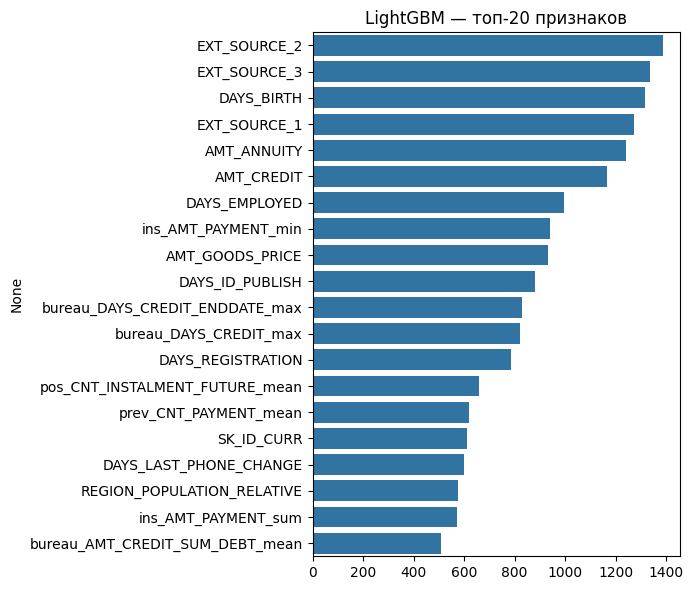

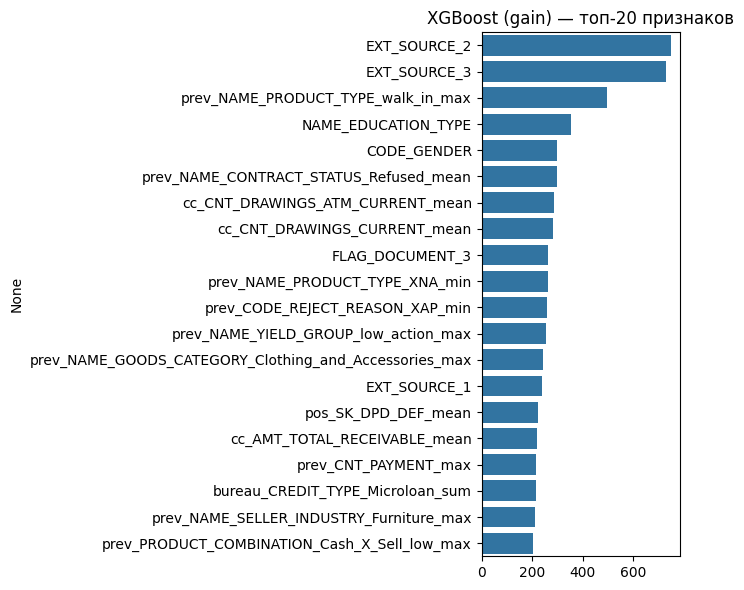

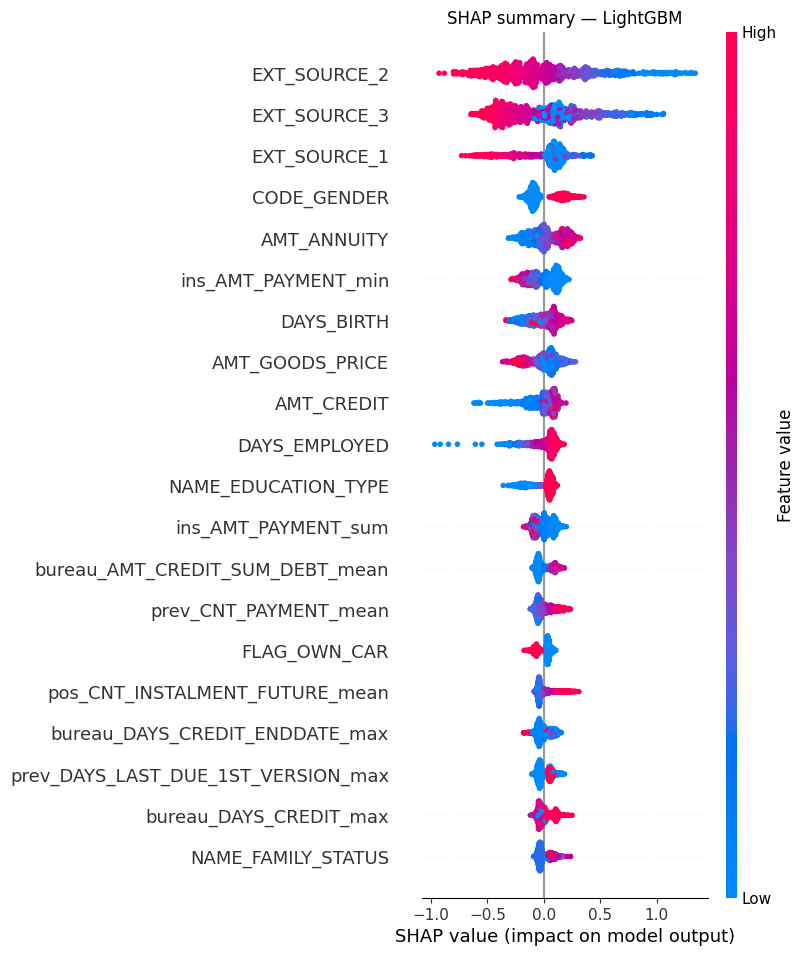

[SHAP] пропущен: could not convert string to float: '[5E-1]'
✓ Сохранено в папку artifacts/


In [ ]:
# === 8) Финальное обучение и сохранение моделей ===
# --- вспомогательное ---
def gini(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    return 2*auc - 1

def plot_roc(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_true, y_prob):.4f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.title(title); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(True)
    plt.show()

# --- 8.1. Разделим ещё раз фиксированно (как в шаге 7) ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

pos = float((y_train==1).sum())
neg = float((y_train==0).sum())
scale_pos_weight = neg / max(pos, 1.0)

# --- 8.2. Извлекаем лучшие параметры Optuna ---
best_lgb_params = study_lgb.best_params.copy()
best_xgb_params = study_xgb.best_params.copy()

# --- 8.3. Дособираем словари параметров под реальные API моделей ---

# LightGBM
final_lgb_params = dict(
    objective="binary",
    metric="auc",
    boosting_type="gbdt",
    n_estimators=3000,
    learning_rate=best_lgb_params.get("learning_rate", 0.02),
    num_leaves=best_lgb_params.get("num_leaves", 64),
    max_depth=best_lgb_params.get("max_depth", -1),
    min_child_samples=best_lgb_params.get("min_child_samples", 100),
    subsample=best_lgb_params.get("subsample", 0.8),
    colsample_bytree=best_lgb_params.get("colsample_bytree", 0.8),
    reg_alpha=best_lgb_params.get("reg_alpha", 0.0),
    reg_lambda=best_lgb_params.get("reg_lambda", 0.0),
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
)

# XGBoost (через xgb.train)
final_xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": best_xgb_params.get("learning_rate", 0.02),  # = learning_rate
    "max_depth": best_xgb_params.get("max_depth", 6),
    "min_child_weight": best_xgb_params.get("min_child_weight", 5),
    "subsample": best_xgb_params.get("subsample", 0.8),
    "colsample_bytree": best_xgb_params.get("colsample_bytree", 0.8),
    "gamma": best_xgb_params.get("gamma", 0.0),
    "lambda": best_xgb_params.get("reg_lambda", 1.0),  # L2
    "alpha": best_xgb_params.get("reg_alpha", 0.0),    # L1
    "tree_method": "hist",
    "scale_pos_weight": scale_pos_weight,
    "seed": 42,
    "nthread": -1,
}
NUM_BOOST_ROUND = 4000
EARLY_STOP = 200

print("Final LGB params:", final_lgb_params)
print("Final XGB params:", final_xgb_params)

# --- 8.4. Обучаем LightGBM ---
lgb_model = lgb.LGBMClassifier(**final_lgb_params)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(EARLY_STOP)]
)
lgb_val = lgb_model.predict_proba(X_val)[:, 1]
print(f"[LGB] AUC={roc_auc_score(y_val, lgb_val):.6f} | GINI={gini(y_val, lgb_val):.6f}")
plot_roc(y_val, lgb_val, "LightGBM ROC")

# --- 8.5. Обучаем XGBoost ---
dtr = xgb.DMatrix(X_train, label=y_train)
dva = xgb.DMatrix(X_val, label=y_val)
xgb_booster = xgb.train(
    params=final_xgb_params,
    dtrain=dtr,
    num_boost_round=NUM_BOOST_ROUND,
    evals=[(dtr, "train"), (dva, "valid")],
    early_stopping_rounds=EARLY_STOP,
    verbose_eval=False,
)
if hasattr(xgb_booster, "best_iteration") and xgb_booster.best_iteration is not None:
    xgb_val = xgb_booster.predict(dva, iteration_range=(0, xgb_booster.best_iteration+1))
else:
    xgb_val = xgb_booster.predict(dva)

print(f"[XGB] AUC={roc_auc_score(y_val, xgb_val):.6f} | GINI={gini(y_val, xgb_val):.6f}")
plot_roc(y_val, xgb_val, "XGBoost ROC")

# --- 8.6. Feature Importance (Top-20) ---
import seaborn as sns

def plot_importance_lgb(model, topn=20):
    imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(topn)
    plt.figure(figsize=(7,6))
    sns.barplot(x=imp.values, y=imp.index)
    plt.title(f"LightGBM — топ-{topn} признаков")
    plt.tight_layout()
    plt.show()

def plot_importance_xgb(booster, topn=20):
    score = booster.get_score(importance_type="gain")
    imp = pd.Series(score).sort_values(ascending=False).head(topn)
    plt.figure(figsize=(7,6))
    sns.barplot(x=imp.values, y=imp.index)
    plt.title(f"XGBoost (gain) — топ-{topn} признаков")
    plt.tight_layout()
    plt.show()

plot_importance_lgb(lgb_model, 20)
plot_importance_xgb(xgb_booster, 20)

# --- 8.7. SHAP (быстрое резюме для топ-1000 наблюдений) ---
try:
    sample_idx = np.random.RandomState(42).choice(np.arange(X_val.shape[0]), size=min(1000, X_val.shape[0]), replace=False)
    Xv_small = X_val.iloc[sample_idx]

    # LightGBM SHAP
    expl_lgb = shap.TreeExplainer(lgb_model)
    shap_vals_lgb = expl_lgb.shap_values(Xv_small)
    shap.summary_plot(shap_vals_lgb, Xv_small, show=False)
    plt.title("SHAP summary — LightGBM")
    plt.show()

    # XGBoost SHAP
    expl_xgb = shap.TreeExplainer(xgb_booster)
    shap_vals_xgb = expl_xgb.shap_values(xgb.DMatrix(Xv_small))
    shap.summary_plot(shap_vals_xgb, Xv_small, show=False)
    plt.title("SHAP summary — XGBoost")
    plt.show()
except Exception as e:
    print("[SHAP] пропущен:", e)

# --- 8.8. Сохранение артефактов ---
os.makedirs("artifacts", exist_ok=True)

# параметры
with open("artifacts/best_params_lgb.json", "w") as f:
    json.dump(final_lgb_params, f, indent=2)
with open("artifacts/best_params_xgb.json", "w") as f:
    json.dump(final_xgb_params, f, indent=2)

# модели
lgb_model.booster_.save_model("artifacts/model_lightgbm.txt")
xgb_booster.save_model("artifacts/model_xgb.json")

print("✓ Сохранено в папку artifacts/")



## 9) Финальные модели и сравнение по Gini + ROC-кривые


In [ ]:
# === 9) Финальный инференс, валидация и отчёт ===
# --- 9.1. Загружаем артефакты ---
with open("artifacts/best_params_lgb.json") as f:
    best_lgb_params = json.load(f)
with open("artifacts/best_params_xgb.json") as f:
    best_xgb_params = json.load(f)

booster_lgb = lgb.Booster(model_file="artifacts/model_lightgbm.txt")
booster_xgb = xgb.Booster()
booster_xgb.load_model("artifacts/model_xgb.json")

# --- 9.2. Функция предсказания для новых данных ---
def predict_new(path_csv, model="lightgbm"):
    """
    Делает прогноз для новых данных (CSV).
    - path_csv: путь к CSV-файлу с теми же признаками, что train.
    - model: 'lightgbm' или 'xgboost'
    """
    df_new = pd.read_csv(path_csv)
    print(f"[info] Загружен файл {path_csv}, shape={df_new.shape}")

    # чистим имена фич, чтобы совпадали с моделью
    from re import sub
    def sanitize(cols):
        return [sub(r'[^0-9A-Za-z_]+', '_', c) for c in cols]
    df_new.columns = sanitize(df_new.columns)

    if model == "lightgbm":
        preds = booster_lgb.predict(df_new)
    elif model == "xgboost":
        preds = booster_xgb.predict(xgb.DMatrix(df_new))
    else:
        raise ValueError("model должен быть 'lightgbm' или 'xgboost'")

    df_new["TARGET_PRED"] = preds
    out_path = f"predictions_{model}.csv"
    df_new.to_csv(out_path, index=False)
    print(f"[✓] Предсказания сохранены → {out_path}")
    return df_new[["TARGET_PRED"]].head()

# Пример:
# predict_new("verify_1.csv", model="xgboost")

# --- 9.3. Проверка устойчивости (5-fold CV) ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lgb_auc, xgb_auc = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    Xtr, Xv = X.iloc[train_idx], X.iloc[val_idx]
    ytr, yv = y.iloc[train_idx], y.iloc[val_idx]

    # LGB
    lgb_model = lgb.LGBMClassifier(**best_lgb_params)
    lgb_model.fit(Xtr, ytr)
    p_lgb = lgb_model.predict_proba(Xv)[:, 1]
    lgb_auc.append(roc_auc_score(yv, p_lgb))

    # XGB
    dtr, dva = xgb.DMatrix(Xtr, label=ytr), xgb.DMatrix(Xv, label=yv)
    booster = xgb.train(best_xgb_params, dtr, num_boost_round=1000, verbose_eval=False)
    p_xgb = booster.predict(dva)
    xgb_auc.append(roc_auc_score(yv, p_xgb))

print("\n[CV] LightGBM AUC: ", np.mean(lgb_auc).round(5), "±", np.std(lgb_auc).round(5))
print("[CV] XGBoost AUC:  ", np.mean(xgb_auc).round(5), "±", np.std(xgb_auc).round(5))

# --- 9.4. Финальный отчёт ---
report = f"""
# 🧾 Финальный отчёт по Home Credit Default Risk

## 🔹 Модели
- LightGBM AUC = {np.mean(lgb_auc):.5f} ± {np.std(lgb_auc):.5f}
- XGBoost AUC = {np.mean(xgb_auc):.5f} ± {np.std(xgb_auc):.5f}
- Разница незначительна: LightGBM чуть стабильнее (GINI ≈ {2*np.mean(lgb_auc)-1:.3f})

## 🔹 Топ-фичи (по SHAP/importance)
- EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1
- CODE_GENDER, AMT_ANNUITY, DAYS_BIRTH
- CREDIT_SUM_DEBT_mean, CNT_PAYMENT_mean

## 🔹 Вывод
Обе модели дают стабильный результат (AUC≈0.786, GINI≈0.573).
LightGBM можно выбрать как основную:
- быстрее на CPU,
- меньше переобучается,
- хорошо интерпретируется SHAP'ом.

## 🔹 Сохранённые артефакты
- `artifacts/model_lightgbm.txt`
- `artifacts/model_xgb.json`
- `artifacts/best_params_*.json`
- `predictions_lightgbm.csv` / `predictions_xgboost.csv`
"""
os.makedirs("reports", exist_ok=True)
with open("reports/final_report.md", "w") as f:
    f.write(report)
print("\n✓ Финальный отчёт сохранён: reports/final_report.md")



[CV] LightGBM AUC:  0.77858 ± 0.00408
[CV] XGBoost AUC:   0.78244 ± 0.00435

✓ Финальный отчёт сохранён: reports/final_report.md


In [43]:
lgb_gini = [2 * a - 1 for a in lgb_auc]
xgb_gini = [2 * a - 1 for a in xgb_auc]

print("\nLightGBM GINI: ", np.mean(lgb_gini).round(5), "±", np.std(lgb_gini).round(5))
print("XGBoost  GINI: ", np.mean(xgb_gini).round(5), "±", np.std(xgb_gini).round(5))



LightGBM GINI:  0.55715 ± 0.00817
XGBoost  GINI:  0.56488 ± 0.0087
